In [1]:
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.models import Model
from keras.preprocessing import image
from keras import models
from keras import layers
from keras import optimizers

Using TensorFlow backend.


In [2]:
from matplotlib import pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
import sys
import os

from PIL import Image

from dotenv import load_dotenv

In [3]:
sys.path.append("../Library/")
import deep_learning as dl
import image_manipulation as ima
import machine_learning as ml

In [4]:
%load_ext autoreload
%autoreload 2

# Load ResNet with 50 Layers

In [5]:
base_model = ResNet50(weights='imagenet',
                      include_top=False,
                      input_shape = (512, 512, 3))

Instructions for updating:
Colocations handled automatically by placer.


/Users/peterweber/Programs/anaconda2/envs/tensorflow/lib/python3.7/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [6]:
base_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 518, 518, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 256, 256, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 256, 256, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

# Image Pipeline Testground

### Test Image

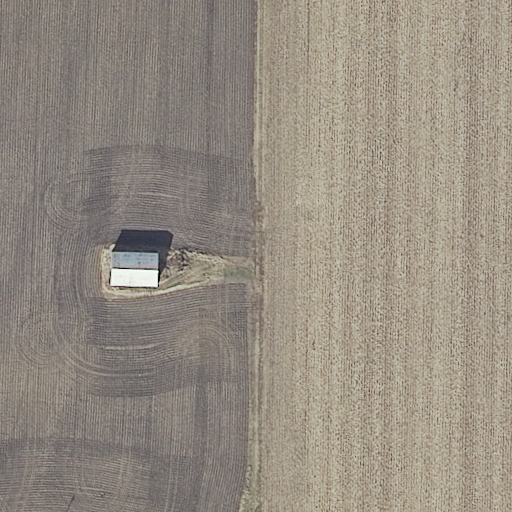

In [8]:
path = "/Users/peterweber/Google Drive/MFP - Satellogic/images/usgs_512_res0.3m/agriculture/16sbj640920_x3780_y2244_size512_baseres0.3m.png"
test_image = image.load_img(path, target_size = (512, 512))
test_image

### Plot Filter Activations of the 2nd Convolutional Layer

In [11]:
activation = dl.get_activations(test_image, base_model, 2)

Shape of input: (1, 512, 512, 3)
Shape of output: (1, 128, 128, 64)


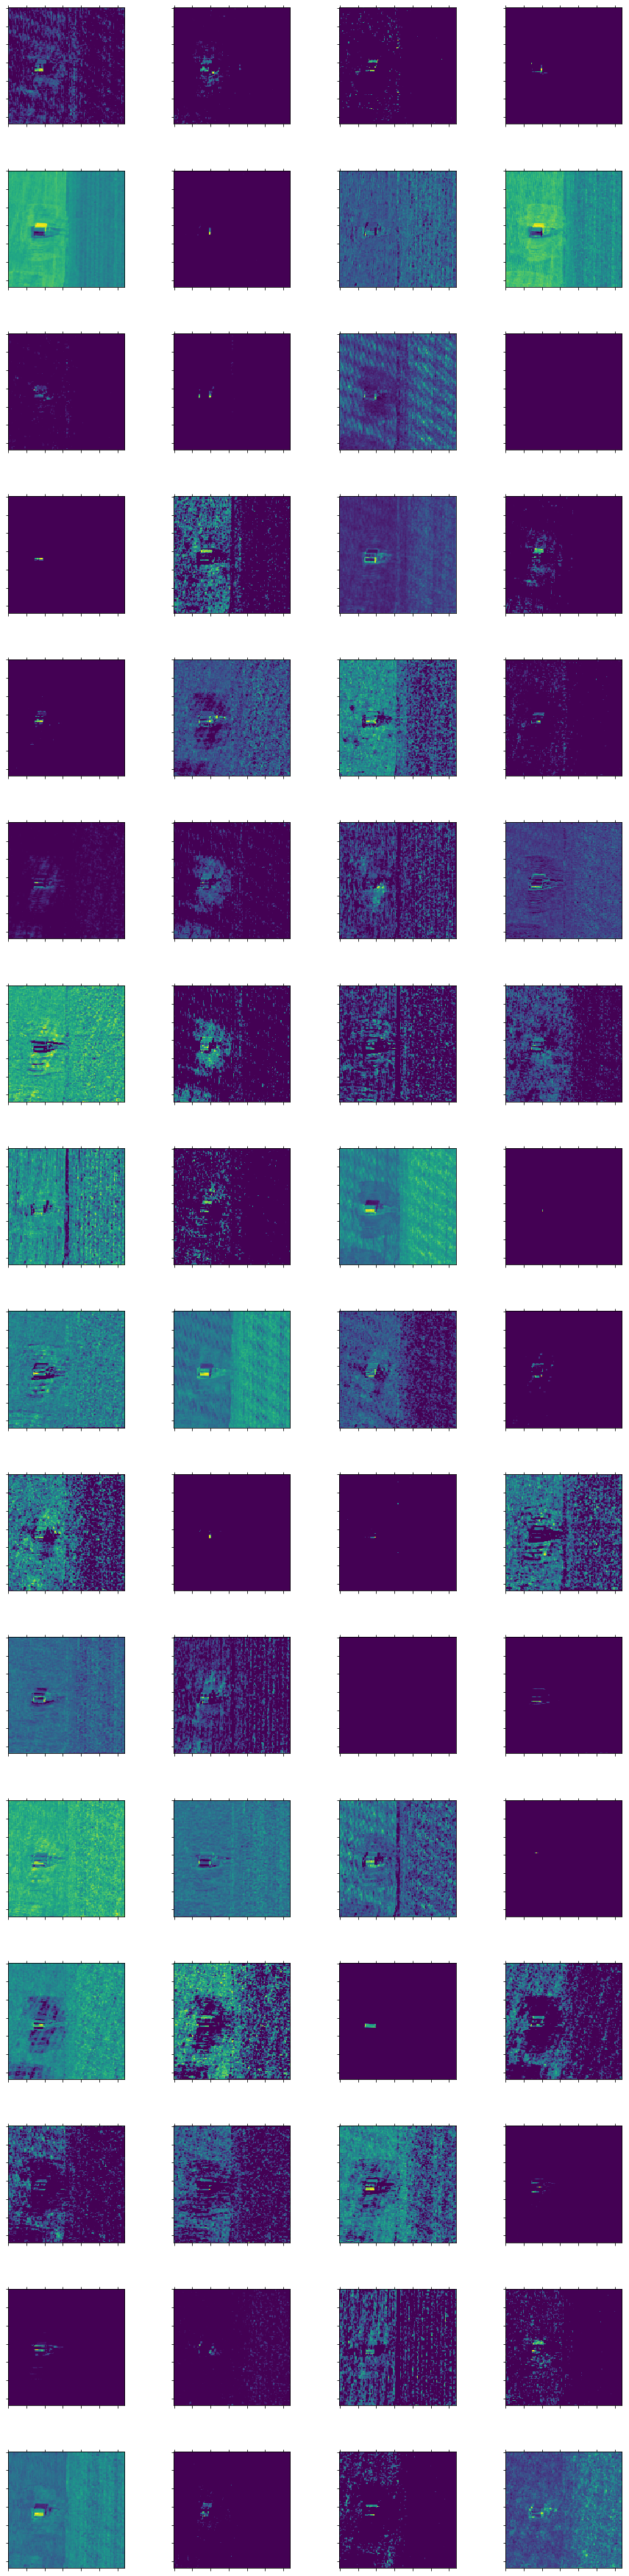

In [12]:
num_filters = activation.shape[3]
columns = 4

fig = plt.figure(figsize=(15, 4*num_filters/columns))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(1, num_filters + 1):
    ax = fig.add_subplot(int(num_filters/columns), columns, i)
    ax.matshow(activation[0, :, :, i-1], cmap='viridis')

    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])

# Load Image Batch

### Define degraded resolutions and image sizes for later use

In [13]:
sizes = {}
base_res = 0.3
base_size = 512
for factor in range(2, 11):
    res = round(base_res * factor,1)
    size = round(base_size/factor)
    sizes[res] = (size, size)
print("\nSizes dictionary:\n", sizes)


Sizes dictionary:
 {0.6: (256, 256), 0.9: (171, 171), 1.2: (128, 128), 1.5: (102, 102), 1.8: (85, 85), 2.1: (73, 73), 2.4: (64, 64), 2.7: (57, 57), 3.0: (51, 51)}


### Load Image Batch into DataFrame

In [16]:
base_folder = "/Users/peterweber/Google Drive/MFP - Satellogic/images/usgs_512_res0.3m"
categories = ["forest-woodland", "agriculture", "shrubland-grassland", "semi-desert"]
labels = [0, 1, 2]

df_images = pd.DataFrame(columns = ['filename', 'image', 'resolution', 'label'])
for category in categories:
    for label in labels:
        df = ima.load_images_into_df_by_category_and_label(base_folder, category, label)
        df_images = df_images.append(df)

df_images.head()

,filename,image,resolution,label
0,11skd505320_x1732_y708_size512_baseres0.3m.png,"[[[64, 91, 53], [68, 95, 53], [72, 95, 51], [6...",0.3,0
1,11skd505320_x2244_y2756_size512_baseres0.3m.png,"[[[19, 28, 28], [13, 23, 27], [15, 23, 26], [1...",0.3,0
2,11skd505320_x1732_y196_size512_baseres0.3m.png,"[[[56, 75, 50], [39, 62, 43], [47, 68, 44], [6...",0.3,0
3,11skd505320_x3268_y2244_size512_baseres0.3m.png,"[[[91, 101, 64], [133, 118, 77], [130, 121, 79...",0.3,0
4,11skd520320_x196_y196_size512_baseres0.3m.png,"[[[68, 96, 56], [72, 100, 55], [57, 71, 52], [...",0.3,0


### Enhance Images DataFrame by Degraded Images
Keep in mind that images are degraded in a way that doesn't change their number of pixels. Specifically, I am
- degrading to smaller size
- enhancing the size of the degraded image to the original image size

I am doing this so that the Neural Network always receives the same input size.

In [17]:
df_degraded = ima.load_degraded_images_into_df(df_images, sizes, label = True)


df_images = df_images.append(df_degraded)
df_degraded.head()

,filename,image,resolution,label
0,11skd505320_x1732_y708_size512_baseres0.3m.png,"[[[71, 97, 52], [71, 97, 52], [55, 72, 45], [5...",0.6,0
1,11skd505320_x2244_y2756_size512_baseres0.3m.png,"[[[14, 24, 28], [14, 24, 28], [11, 21, 26], [1...",0.6,0
2,11skd505320_x1732_y196_size512_baseres0.3m.png,"[[[52, 75, 47], [52, 75, 47], [68, 86, 52], [6...",0.6,0
3,11skd505320_x3268_y2244_size512_baseres0.3m.png,"[[[121, 110, 72], [121, 110, 72], [134, 123, 8...",0.6,0
4,11skd520320_x196_y196_size512_baseres0.3m.png,"[[[68, 92, 54], [68, 92, 54], [46, 59, 46], [4...",0.6,0


### Generate data det X and y that can be fed into an ML algorithm

In [19]:
RESOLUTION = 0.3

X, y = dl.generate_X_y_from_df(df_images, RESOLUTION)

Shape of image array is: (162, 512, 512, 3)


### Extract Convolutional Net Activations for Image Batch

In [20]:
X = dl.get_activations(X, base_model, activation = 2)

Shape of input: (162, 512, 512, 3)
Shape of output: (162, 128, 128, 64)


# Next: 
### option 1
Feed Activations of ResNet into Fully Connected Network

### option 2
Feed Activations of ResNet into any other classifier